In [56]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

In [2]:
d2l.use_svg_display()

In [3]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root='../p1/data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root='../p1/data', train=False, transform=trans, download=True)


100.0%


Extracting ../p1/data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../p1/data\FashionMNIST\raw



100.0%


Extracting ../p1/data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../p1/data\FashionMNIST\raw



100.0%


Extracting ../p1/data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../p1/data\FashionMNIST\raw



100.0%

Extracting ../p1/data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../p1/data\FashionMNIST\raw



In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [9]:
def get_fashion_mnist_labels(labels):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot' ]
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])

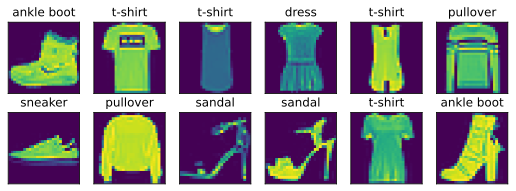

In [39]:
X, y =  next(iter(data.DataLoader(mnist_train, batch_size=12)))
show_images(X.reshape(12, 28, 28), 2, 6, titles=get_fashion_mnist_labels(y))

In [40]:
batch_size = 256

def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [31]:
timer = d2l.Timer()

for X, y in train_iter:
    continue
f'{timer.stop():.2f} seconds'

'3.88 seconds'

In [54]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../p1/data", train=True, transform=trans, download=True)
    mnist_test  = torchvision.datasets.FashionMNIST(root="../p1/data", train=True, transform=trans, download=True)
    
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,  num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test,  batch_size, shuffle=False, num_workers=get_dataloader_workers()))
    
    

torch.Size([32, 1, 128, 128]) torch.float32 torch.Size([32]) torch.int64


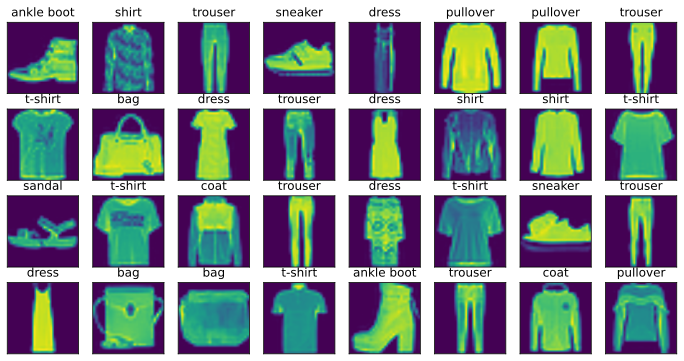

In [ ]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=128)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    show_images(X.reshape(-1, 128, 128), 4, 8, titles=get_fashion_mnist_labels(y))
    break

In [61]:
def accuracy(y_pred, y):
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)
    cmp = y_pred.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = d2l.Accumulator(2) # count (1) num of accurate predictions and (2) total num of predictions
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

    
    

In [75]:
def train_epoch(net, train_iter, optimizer):
    if isinstance(net, nn.Module):
        net.train()
    # count (1) total training loss, (2) total training accuracy, and (3) num of samples
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_pred = net(X)
        criterion = nn.CrossEntropyLoss(reduction='none')
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        metric.add(float(loss.sum()), accuracy(y_pred, y), y.numel())
        
    return metric[0] / metric[2], metric[1] / metric[2]

def train(net, train_iter, test_iter, num_epochs, optimizer):
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'],)
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
        
        

In [76]:
net = nn.Sequential(nn.Flatten(), nn.Linear(28 * 28, 10))

def init_weights(m):
    if type(m) == nn.Module:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

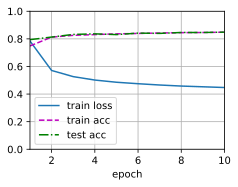

In [77]:
num_epochs = 10
train(net, train_iter, test_iter, num_epochs=num_epochs, optimizer=optimizer)

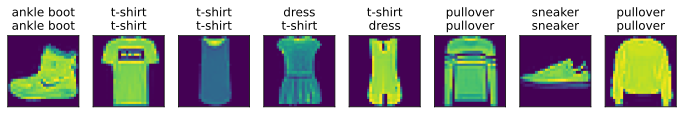

In [78]:
def predict(net, test_oter, n=8):
    for X, y in test_iter:
        break
    true_labels = get_fashion_mnist_labels(y)
    pred_labels = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
    
    show_images(
        X[0:n].reshape(-1, 28, 28), 1, n, titles=titles[0:n]    
    )
    
predict(net, test_iter)